In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

# Week 13, ASTR 596: Fundamentals of Data Science


## Density-based clustering methods, Anomaly Detection, Dealing with Errors

### Gautham Narayan 
##### <gsn@illinois.edu>

## Recap

- Parametric methods of clustering (k-means, GMMs)
    - stochastic - results depend on initial guesses and number of clusters
    - k-means is **centroid-based** - separating sample into ~equal numbers of objects in each of $k$ clusters
    - GMMs is **distribution-based** - assume a shape for a distribution (and therefore density) and model the data as being drawn from that distribution

- Neither work well when the cluster is defined in terms of density of points

<table>
    <tr>
        <th>
            <img src="KMeans-density-data.svg.png", width="80%">
        </th>
        <th>
            <img src="EM-density-data.svg.png">
        </th>        
    </tr>
</table>

 
- Clustering is more general than finding groups of similar things - **density estimation**
    - Non-parametric methods (kernel density estimation -> hierarchical clustering)
        - deterministic - you'll get the exact same results each time and you don't have to pick a number of clusters
        - **linkage/connectivity-based** 
            - **agglomerative** - hierarchical clustering builds up clusters by associating points together
        - Because you have to build a tree structure out of $N$ datapoints, these methods are inefficient for large $N$ ($O(n^3)$ for hierarchical clustering) 
        - there is no notion of *noise* - outliers can become their own clusters - or worse an outlier from two clusters can caused both to be linked incorrectly
        
<img src="HLINK-density-data.svg.png">

        
        
        

## Density-based clustering

- Rather than a linkage based approach that which considers $k$ neighbors to each point (regardless of distance modulo some overall distance threshold), these approaches look at how closely packed points are - i.e. the **local density**

- Points that are in low-density regions are marked as **outliers**
    - effectively demand that each point have at least MinPts neighbors within some distance, epsilon


Implementation:
    - Pick a random point in the data that hasn't been checked yet
    - Given some epsilon, find if there are at least MinPts within epsilon of point
        - if yes
            - start a cluster
        - else
            - mark as noise (may be later marked as member of a different cluster)
        - mark any points within epsilon of cluster points as also part of the cluster
        - grow cluster until there are no other points that can be added
    - repeat until all points visited          

- Common implementations: DBSCAN and OPTICS (both in `sklearn.cluster`)
    - OPTICS handles clusters with different densities better but is significantly slower
- not completely deterministic - depends on order points are visited, but still **agglomerative** (compare vs decision trees that splits the data up into smaller groups - **divisive** 
- still don't need to specify a number of clusters or cluster centers/widths - i.e. clusters can have arbitrary shapes rather than say a GMM
    - can be fiddly and needs some fine-tuning of epsilon **LOOK AT YOUR DATA**
    

 ## Uses in Astrophysics 
 
 <img src="gamma_DBSCAN.jpg">
 
 Finding clusters in Fermi-LAT $\gamma$ ray data: https://www.aanda.org/articles/aa/abs/2013/01/aa20133-12/aa20133-12.html
 
 
Gamma-ray astronomers could feasibly name all their photons, so finding clusters this way is really looking for overdensities on a map that is otherwise white noise - because number counts are so low, detections are very significant, but this is a way to automate over large area
 

The opposite problem also works - the background is high and the clusters are barely variation on the background:

<img src="GAIA_DR2_clusters.jpg">

And of course, you don't have to do this in RA, Dec space at all - here in 15 dimensional PCA on spectra space:

<img src="Clustering_chem_abundances.png">

## In-class exercise (since you've been deprived):

There's some noisy real color-magnitude data for stars in `colormag.csv`

1. preprocess the data (i.e. scale the magnitudes and colors in some way that makes your results insenstivie to the scale of the values

2. use k-means, GMMs, hierarchical clustering and DBSCAN to cluster the dataset into similar groups. You can pick the sizes of clusters/initial estimates for parameters however you like

3. in each case, the clustering instance that you create will have a `.labels_` attribute - use this to color the points in a scatter plot 


Each of you in a team can take one approach and work in parallel, or work together as you like

In [2]:
## YOUR SOLUTION HERE

import pandas as pd
X = pd.read_csv('colormag.csv', names=['color', 'mag'])

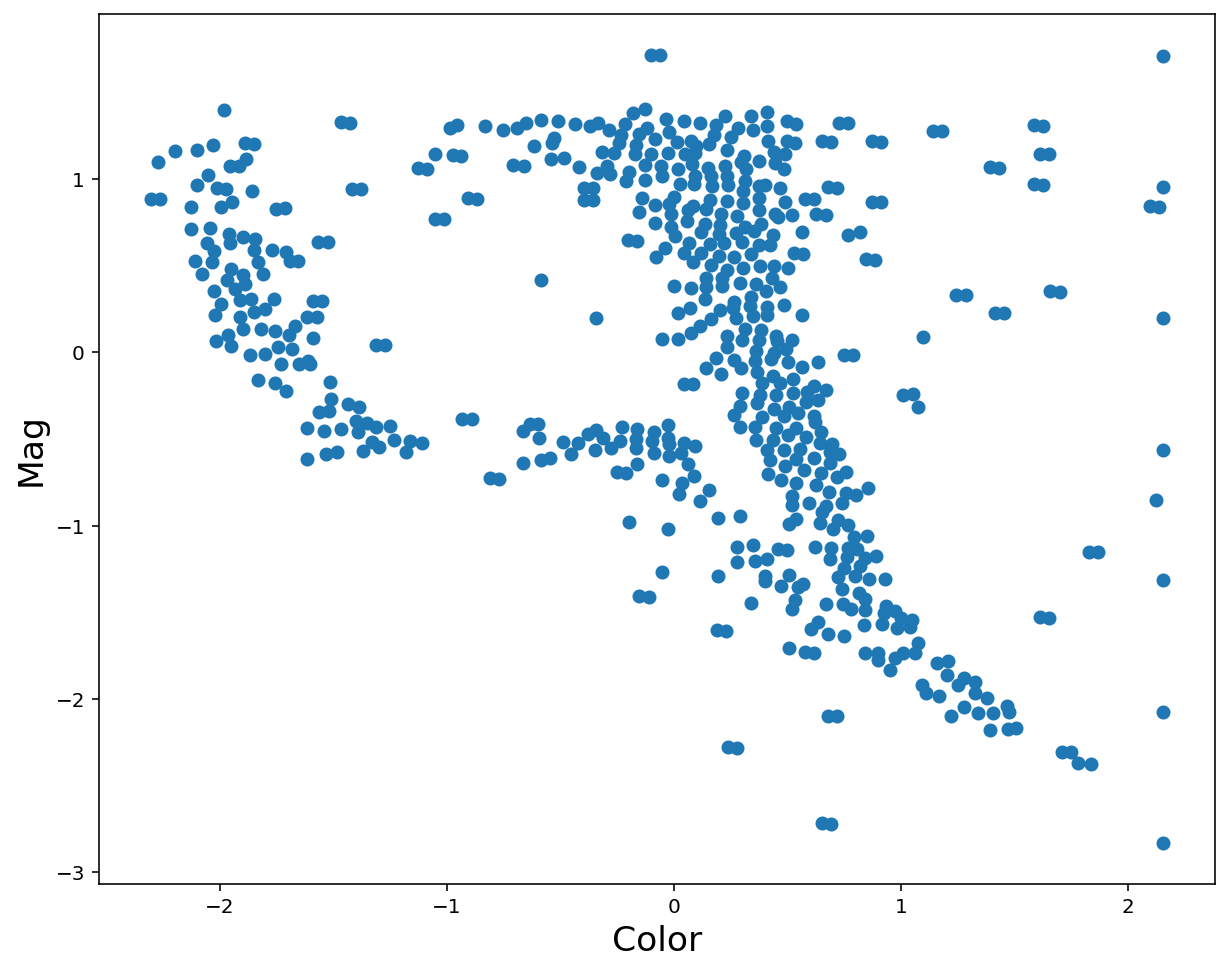

In [3]:
import sklearn
from sklearn.preprocessing import StandardScaler
z = StandardScaler()
Xt = z.fit_transform(X)
scatter(Xt[:,0], Xt[:,1])
ax = plt.gca()
ax.set_xlabel('Color', fontsize='xx-large')
ax.set_ylabel('Mag', fontsize='xx-large');

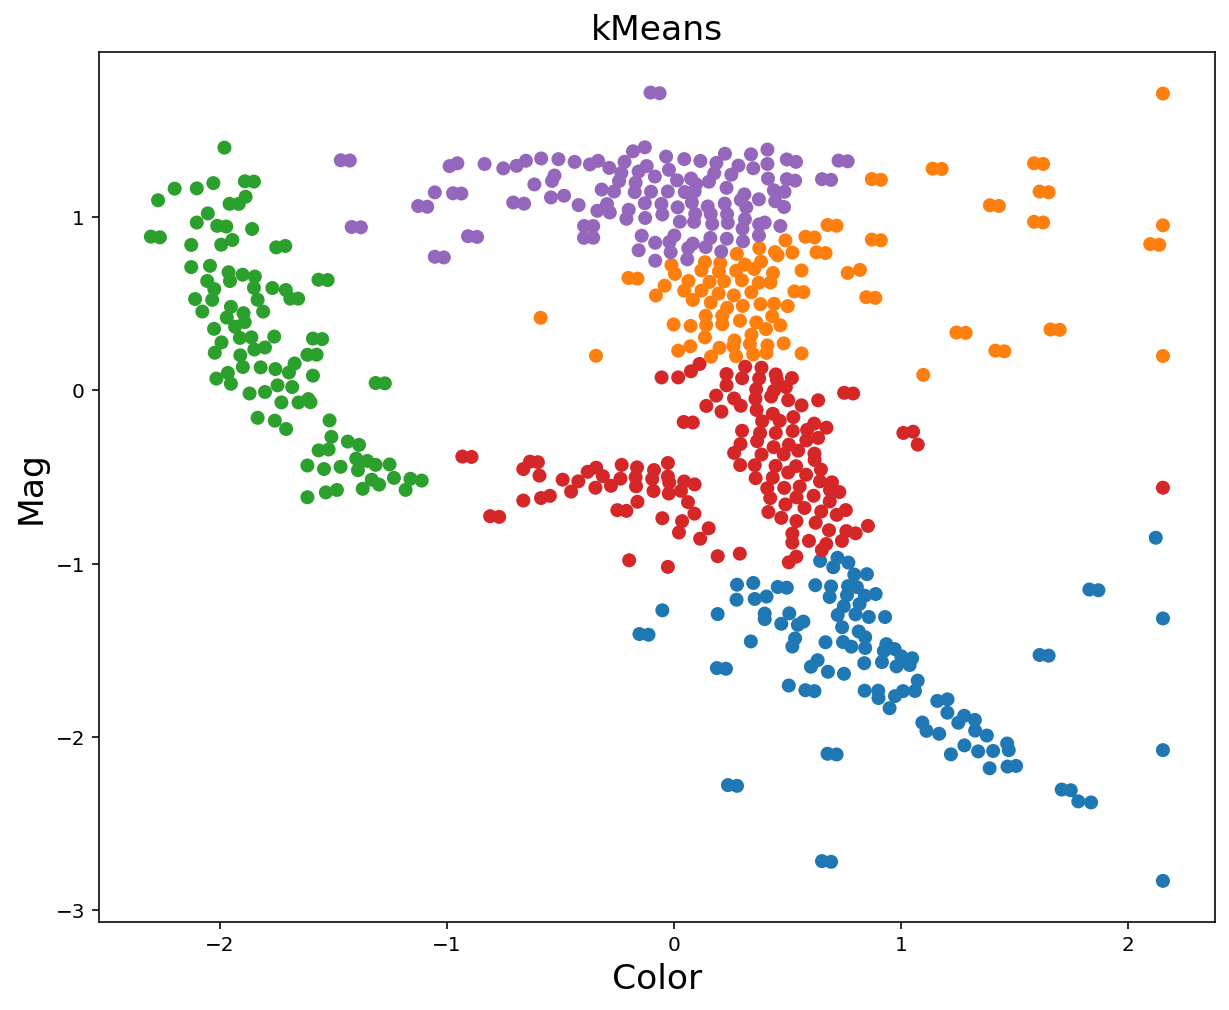

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, KMeans

gmm = GaussianMixture(n_components=5, covariance_type='full')
gmm.fit(Xt)
labels = gmm.predict(Xt)

color = [f'C{i}' for i in labels]
scatter(Xt[:,0], Xt[:,1], color=color)
ax = plt.gca()
ax.set_xlabel('Color', fontsize='xx-large')
ax.set_ylabel('Mag', fontsize='xx-large')
ax.set_title('kMeans', fontsize='xx-large');

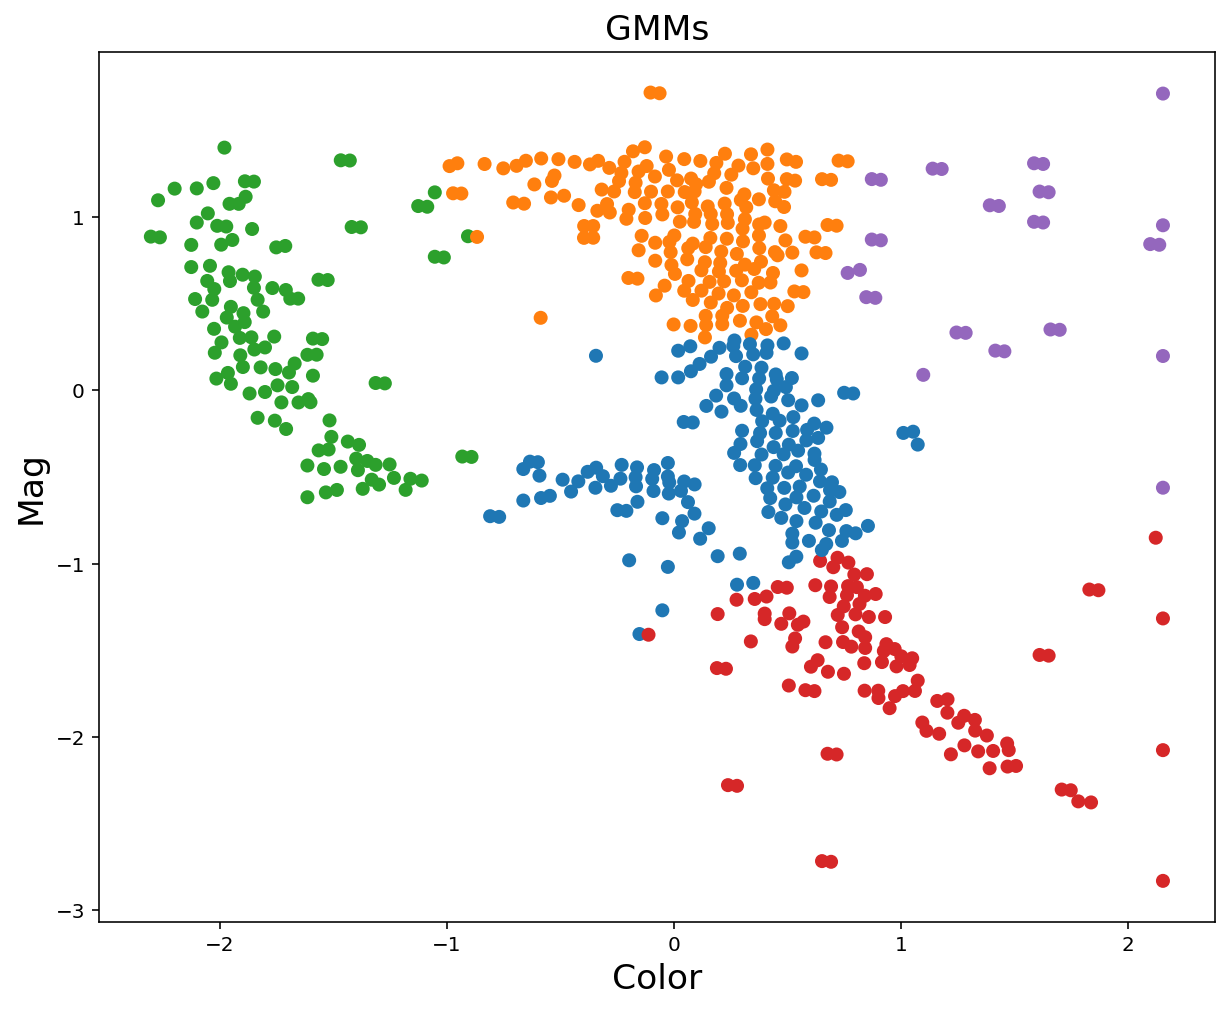

In [5]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(Xt)
labels = kmeans.labels_
color = [f'C{i}' for i in labels]
scatter(Xt[:,0], Xt[:,1], color=color)
ax = plt.gca()

ax.set_xlabel('Color', fontsize='xx-large')
ax.set_ylabel('Mag', fontsize='xx-large')
ax.set_title('GMMs', fontsize='xx-large');

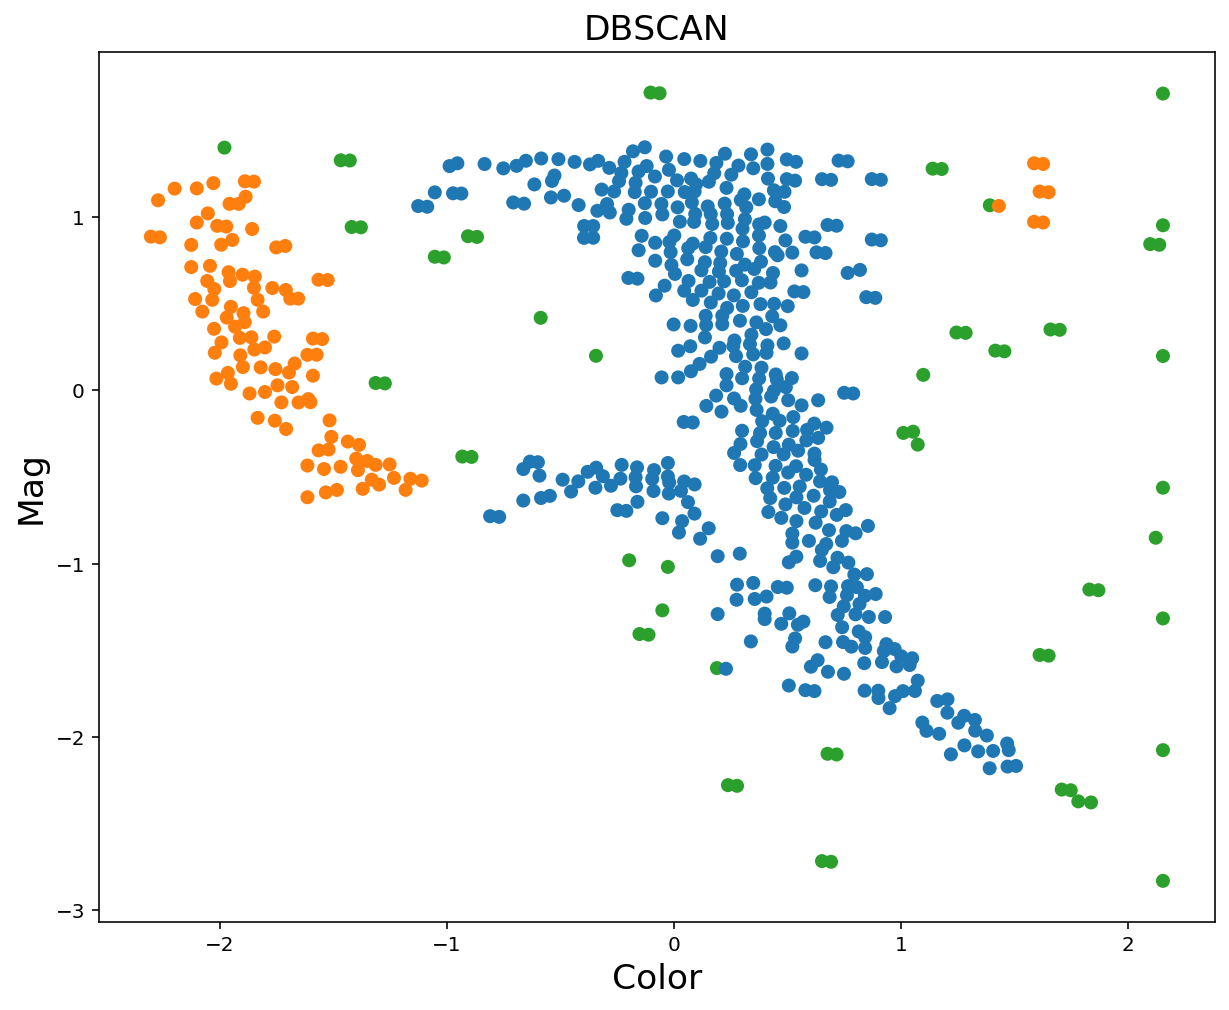

In [6]:
dbs = DBSCAN(eps=0.2, min_samples=5)
dbs.fit(Xt)
labels = dbs.labels_
labels += labels.min()
labels = np.abs(labels)
color = [f'C{i}' for i in labels]
scatter(Xt[:,0], Xt[:,1], color=color)
ax = plt.gca()
ax.set_xlabel('Color', fontsize='xx-large')
ax.set_ylabel('Mag', fontsize='xx-large')
ax.set_title('DBSCAN', fontsize='xx-large');

## Extreme Deconvolution

Real data come with uncertainties

Extreme Deconvolution is parametric density estimation on a *noisy* d-dimensional dataset
- Straightforward generalization of Gaussian Mixture Models conceptually but much slower
    

You have some real obsevations $\mathbf{x}_i$ in d-dimensions *with zero-mean Gaussian noise* $\epsilon_i$ with known per-datapoint covariance $S_i$ to a projection $R_i$ of a true value $\mathbf{v}_i$


## $$
\mathbf{x}_{i}=R_{i} \mathbf{v}_{i}+\epsilon_{i}, \quad \epsilon_{i} \sim \mathcal{N}\left(\mathbf{0}, S_{i}\right)
$$

We assume that $\mathbf{v}_i$ can be modelled by a mixture of Gaussians with K components (i.e. a GMM):

## $$
p\left(\mathbf{v}_{i} | \theta\right)=\sum_{j}^{K} \alpha_{j} \mathcal{N}\left(\mathbf{v} | \mathbf{\mu}_{j}, \Sigma_{j}\right)$$

with the components mean the mean, covariance and mixture coefficients of each Gaussian being the parameters that we solve for as before:

## $$\theta=\left\{\alpha_{j}, \mathbf{\mu}_{j}, \Sigma_{j}\right\}_{j=1}^{K}
$$


Just as before the likelihood is easy:
## $$
\mathcal{L}(\theta)=\sum_{i}^{N} \log \sum_{j}^{K} \alpha_{j} \mathcal{N}\left(\mathbf{x}_{i} | R_{i} \mathbf{\mu}_{j}, C_{i j}\right)$$

#### BUT NOW THE COVARIANCE MATRIX INCLUDES THE ERRORS IN THE OBSERVATIONS

## $$ C_{i j}=R_{i} \Sigma_{j} R_{i}^{T}+S_{i}
$$

Proceed with EM as before, except now instead of estimating the covariance of just the $k$ GMM components, you now have the the $n \times n$ covariance matrix of the observations.

This is unfortunate because the covariance matrix appears as the inverse in the likelihood.

In [7]:
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from astroML.density_estimation import XDGMM
from astroML.crossmatch import crossmatch
from astroML.datasets import fetch_sdss_S82standards, fetch_imaging_sample
from astroML.plotting.tools import draw_ellipse
from astroML.utils.decorators import pickle_results
from astroML.stats import sigmaG

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

In [8]:
#------------------------------------------------------------
# define u-g-r-i-z extinction from Berry et al, arXiv 1111.4985
# multiply extinction by A_r
extinction_vector = np.array([1.810, 1.400, 1.0, 0.759, 0.561])

#----------------------------------------------------------------------
# Fetch and process the noisy imaging data
data_noisy = fetch_imaging_sample()

# select only stars
data_noisy = data_noisy[data_noisy['type'] == 6]

# Get the extinction-corrected magnitudes for each band
X = np.vstack([data_noisy[f + 'RawPSF'] for f in 'ugriz']).T
Xerr = np.vstack([data_noisy[f + 'psfErr'] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
X -= (extinction_vector * data_noisy['rExtSFD'][:, None])

In [9]:
#----------------------------------------------------------------------
# Fetch and process the stacked imaging data
data_stacked = fetch_sdss_S82standards()

# cut to RA, DEC range of imaging sample
RA = data_stacked['RA']
DEC = data_stacked['DEC']
data_stacked = data_stacked[(RA > 0) & (RA < 10) &
                            (DEC > -1) & (DEC < 1)]

# get stacked magnitudes for each band
Y = np.vstack([data_stacked['mmu_' + f] for f in 'ugriz']).T
Yerr = np.vstack([data_stacked['msig_' + f] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
Y -= (extinction_vector * data_stacked['A_r'][:, None])

# quality cuts
g = Y[:, 1]
mask = ((Yerr.max(1) < 0.05) &
        (g < 20))
data_stacked = data_stacked[mask]
Y = Y[mask]
Yerr = Yerr[mask]

In [10]:
#----------------------------------------------------------------------
# cross-match
#  the imaging sample contains both standard and variable stars.  We'll
#  perform a cross-match with the standard star catalog and choose objects
#  which are common to both.
Xlocs = np.hstack((data_noisy['ra'][:, np.newaxis],
                   data_noisy['dec'][:, np.newaxis]))
Ylocs = np.hstack((data_stacked['RA'][:, np.newaxis],
                   data_stacked['DEC'][:, np.newaxis]))

print("number of noisy points:  ", Xlocs.shape)
print("number of stacked points:", Ylocs.shape)

# find all points within 0.9 arcsec.  This cutoff was selected
# by plotting a histogram of the log(distances).
dist, ind = crossmatch(Xlocs, Ylocs, max_distance=0.9 / 3600)

noisy_mask = (~np.isinf(dist))
stacked_mask = ind[noisy_mask]

# select the data
data_noisy = data_noisy[noisy_mask]
X = X[noisy_mask]
Xerr = Xerr[noisy_mask]

data_stacked = data_stacked[stacked_mask]
Y = Y[stacked_mask]
Yerr = Yerr[stacked_mask]

# double-check that our cross-match succeeded
assert X.shape == Y.shape
print("size after crossmatch:", X.shape)

number of noisy points:   (82003, 2)
number of stacked points: (13377, 2)
size after crossmatch: (12313, 5)


In [11]:
#----------------------------------------------------------------------
# perform extreme deconvolution on the noisy sample

# first define mixing matrix W
W = np.array([[0, 1, 0, 0, 0],    # g magnitude
              [1, -1, 0, 0, 0],   # u-g color
              [0, 1, -1, 0, 0],   # g-r color
              [0, 0, 1, -1, 0],   # r-i color
              [0, 0, 0, 1, -1]])  # i-z color

X = np.dot(X, W.T)
Y = np.dot(Y, W.T)

# compute error covariance from mixing matrix
Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
Xcov[:, range(Xerr.shape[1]), range(Xerr.shape[1])] = Xerr ** 2

# each covariance C = WCW^T
# best way to do this is with a tensor dot-product
Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))

In [12]:
#----------------------------------------------------------------------
# This is a long calculation: save results to file
@pickle_results("XD_stellar.pkl")
def compute_XD(n_clusters=12, rseed=0, max_iter=100, verbose=True):
    np.random.seed(rseed)
    clf = XDGMM(n_clusters, max_iter=max_iter, tol=1E-5, verbose=verbose)
    clf.fit(X, Xcov)
    return clf


clf = compute_XD(12)

#------------------------------------------------------------
# Fit and sample from the underlying distribution
np.random.seed(42)
X_sample = clf.sample(X.shape[0])

@pickle_results: using precomputed results from 'XD_stellar.pkl'


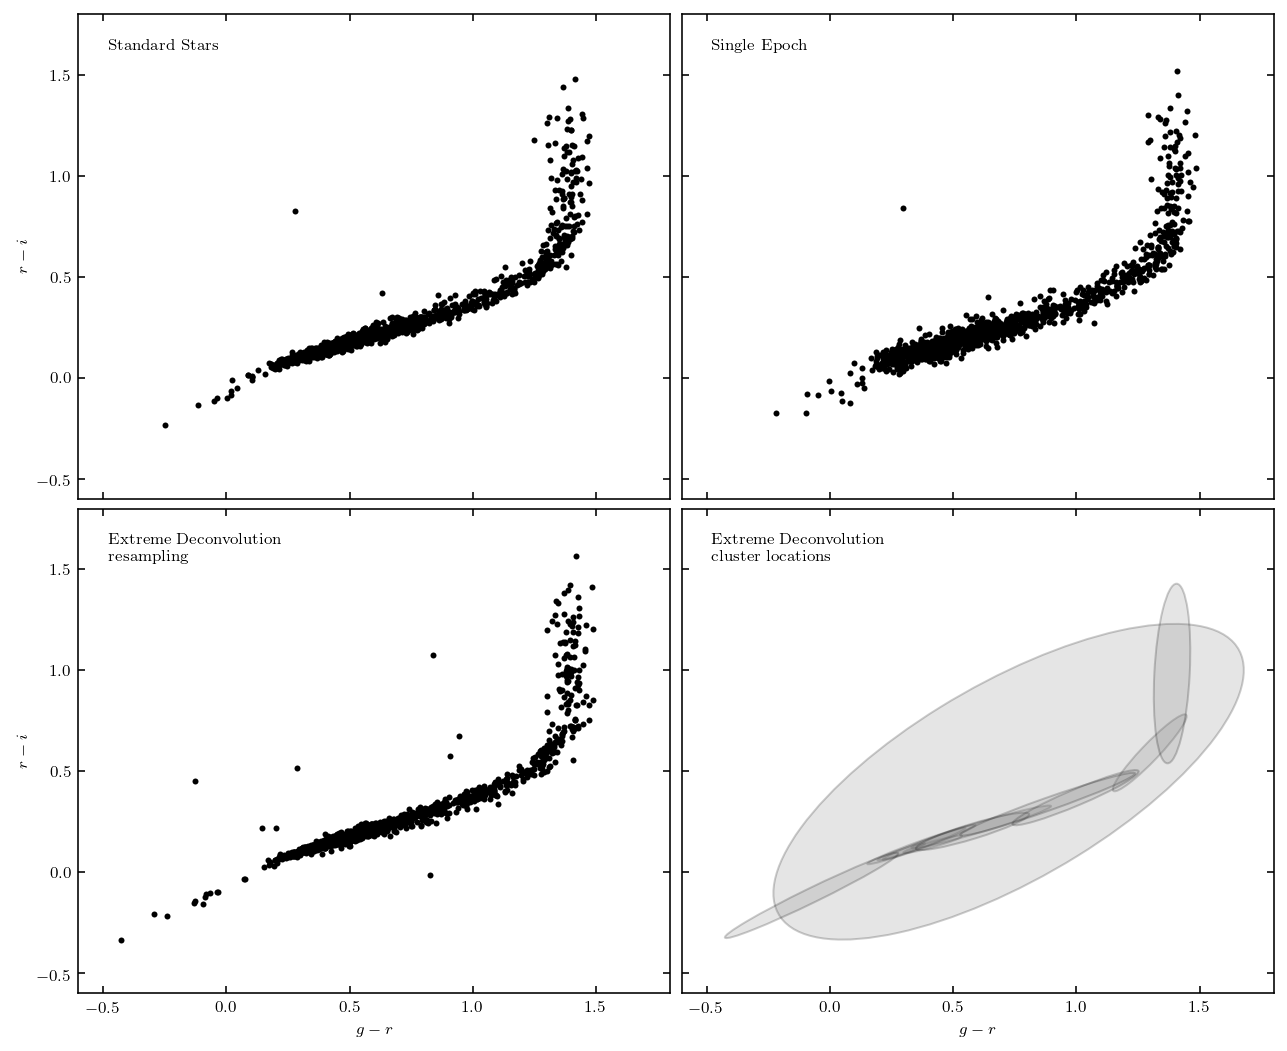

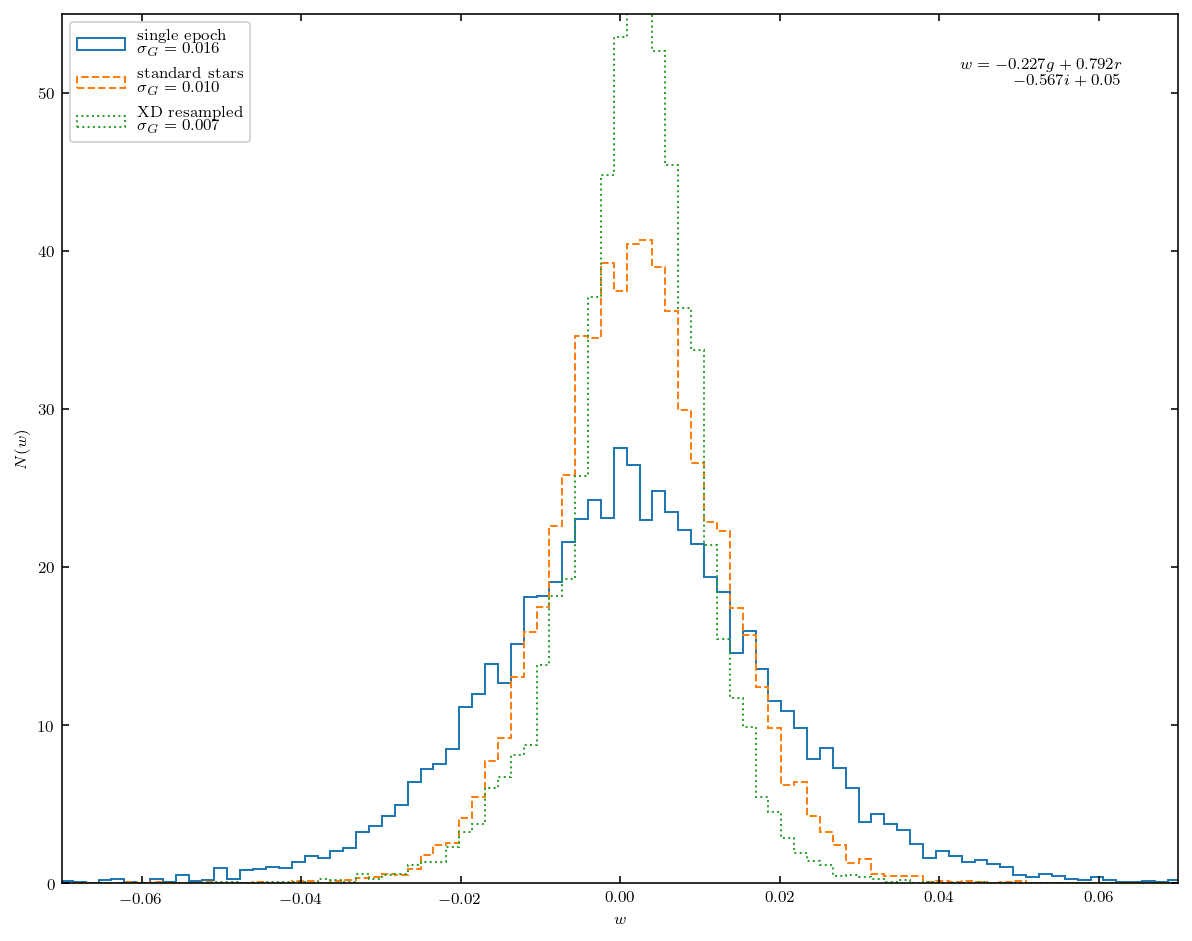

In [13]:
#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.12, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

# only plot 1/10 of the stars for clarity
ax1 = fig.add_subplot(221)
ax1.scatter(Y[::10, 2], Y[::10, 3], s=9, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(X[::10, 2], X[::10, 3], s=9, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(X_sample[::10, 2], X_sample[::10, 3], s=9, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i, 2:4], clf.V[i, 2:4, 2:4], scales=[2],
                 ec='k', fc='gray', alpha=0.2, ax=ax4)

titles = ["Standard Stars", "Single Epoch",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]
ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-0.6, 1.8)
    ax[i].set_ylim(-0.6, 1.8)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(0.5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$g-r$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$r-i$')

#------------------------------------------------------------
# Second figure: the width of the locus
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

labels = ['single epoch', 'standard stars', 'XD resampled']
linestyles = ['solid', 'dashed', 'dotted']
for data, label, ls in zip((X, Y, X_sample), labels, linestyles):
    g = data[:, 0]
    gr = data[:, 2]
    ri = data[:, 3]

    r = g - gr
    i = r - ri

    mask = (gr > 0.3) & (gr < 1.0)
    g = g[mask]
    r = r[mask]
    i = i[mask]

    w = -0.227 * g + 0.792 * r - 0.567 * i + 0.05

    sigma = sigmaG(w)

    ax.hist(w, bins=np.linspace(-0.08, 0.08, 100), linestyle=ls,
            histtype='step', label=label + '\n\t' + r'$\sigma_G=%.3f$' % sigma,
            density=True)

ax.legend(loc=2)
ax.text(0.95, 0.95, '$w = -0.227g + 0.792r$\n$ - 0.567i + 0.05$',
        transform=ax.transAxes, ha='right', va='top')

ax.set_xlim(-0.07, 0.07)
ax.set_ylim(0, 55)

ax.set_xlabel('$w$')
ax.set_ylabel('$N(w)$')

plt.show()

## Anomaly Detection

ML algorithms suffer in terms of their performance when outliers are not taken care of. 

Bad ideas include 
- dropping them from your sample
- leaving them in, using ML methods, and then ignoring the impact of the outliers


Imagine if a bank did either of these for fradulent credit card transactions...

One efficient way of performing outlier detection in high-dimensional datasets is to use random forests

Isolation forests ‘isolate’ observations by constructing decesion trees:
- randomly selecting a feature and then 
- randomly selecting a split value between the maximum and minimum values of the selected feature

Number of splittings required to isolate a sample = path length from the root node to the terminating node

Path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeable shorter paths for anomalies. 

When a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies - i.e. **linkage-based**

<img src="IsolationForest1.png">

Random forest are **supervised** so why are they showing up here in **unsupervised learning**?
- there's only two labels (outlier/not outlier)
- but you still have to condition the algorithm on a training set (even if it doesn't have labels) 


## Local Outlier Fraction:

LOF uses density-based outlier detection to identify local outliers
- points that are outliers with respect to their local neighborhood, rather than with respect to the global distribution. 

A point is labeled as an outlier if the density around that point is significantly different from the density around its neighbors.
  
The higher the LOF value for an observation, the more anomalous the observation.

Useful because can identify a point that’s an outlier relative to a nearby cluster of points (a local outlier) even if that whole region is an outlying region in the global space of data points.
    - Application SNIa have subclasses that are odd, and even amongst those sub-classes there are real oddballs - these are good to identify because they tell us the most about the physics of the explosion.


<img src="LOF.png">

## In class-exercise:

Train an isolation forest and LOF on a random subset of the color-mag data. 

(For isolation forest, you can use `sklearn.model_selection.train_test_split` to split it into a training set and test set)

and as before train the algoritin 

```
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
```

or with `sklearn.neighbors.LocalOutlierFactor`

```
clf = LocalOutlierFactor(n_neighbors=2)
clf.fit_predict(X)
```

In [14]:
## YOUR CODE HERE
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

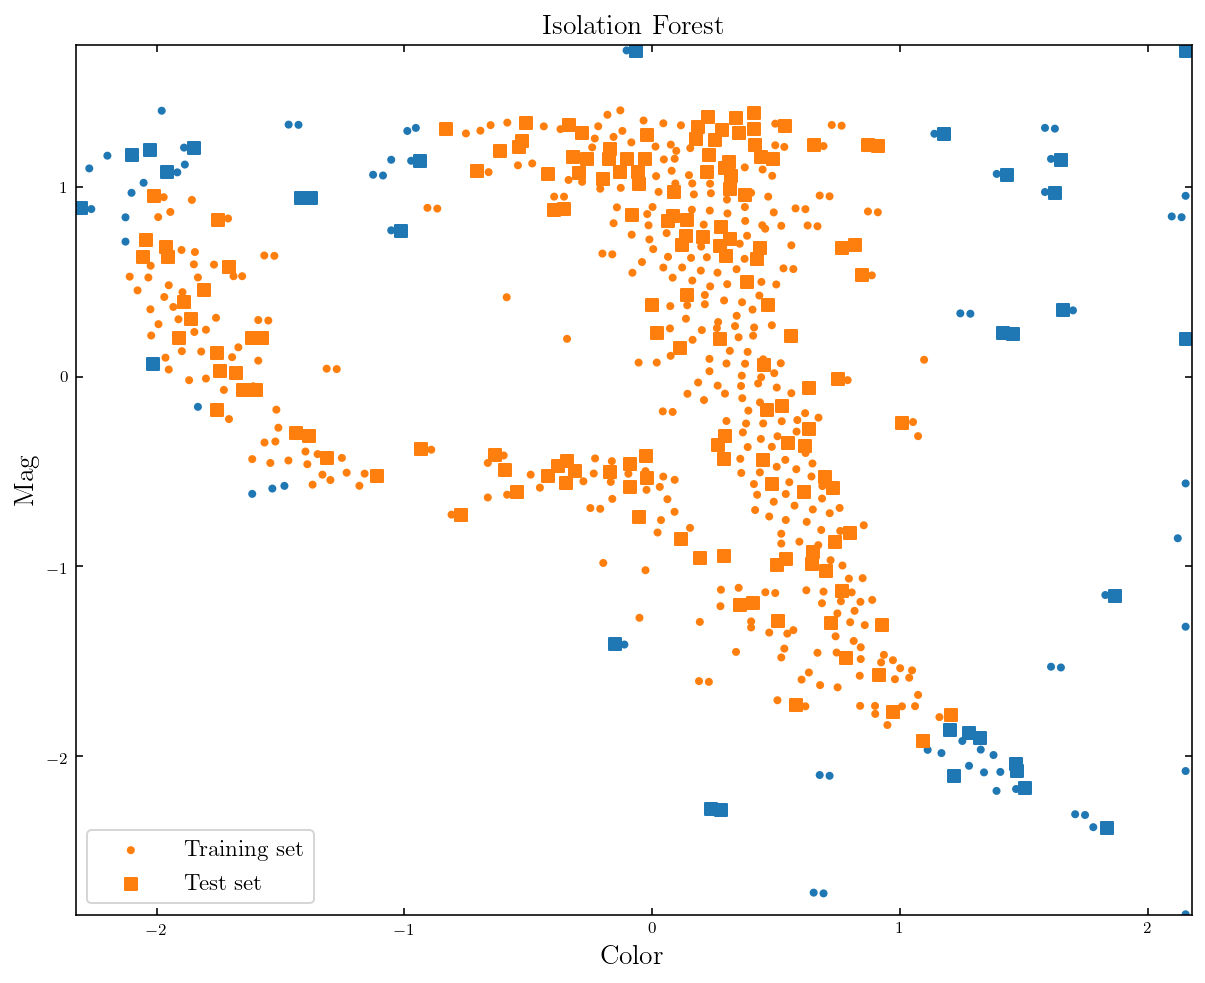

In [15]:
Xtrain, Xtest = train_test_split(Xt, test_size=0.3)
clf = IsolationForest(max_samples='auto', contamination=0.15)
clf.fit(Xtrain)
y_pred_train = clf.predict(Xtrain)
y_pred_test = clf.predict(Xtest)

#outliers are -1, inliers are 1
y_pred_train[y_pred_train == -1] += 1
y_pred_test[y_pred_test == -1] += 1

color_train = [f'C{i}' for i in y_pred_train]
scatter(Xtrain[:,0], Xtrain[:,1], color=color_train, marker='.', label='Training set')
color_test = [f'C{i}' for i in y_pred_test]
scatter(Xtest[:,0], Xtest[:,1], color=color_test, marker='s', label='Test set')

ax = plt.gca()
ax.legend(fontsize='x-large', loc='lower left')

ax.set_xlabel('Color', fontsize='xx-large')
ax.set_ylabel('Mag', fontsize='xx-large')
ax.set_title('Isolation Forest', fontsize='xx-large');

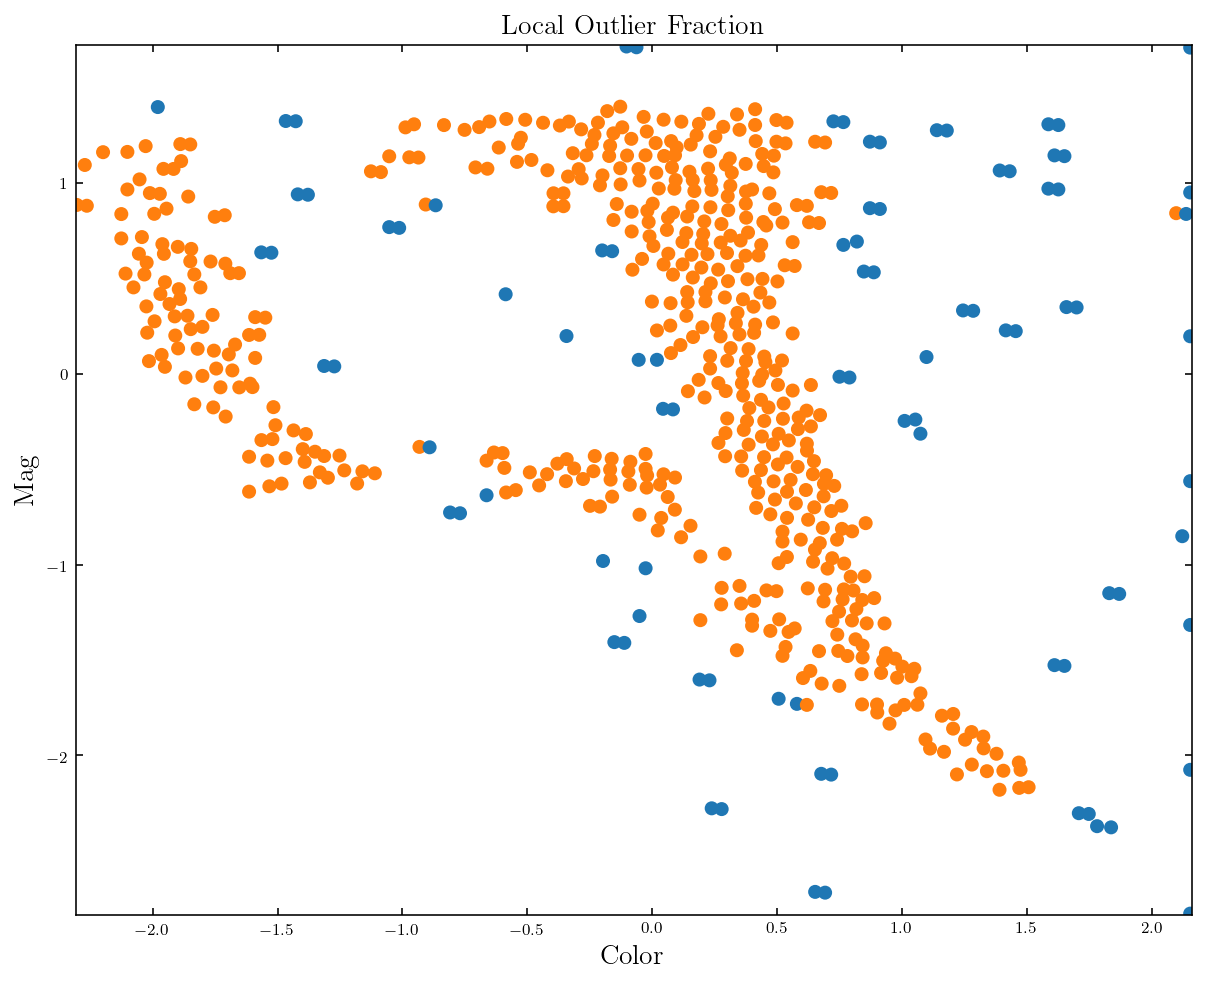

In [16]:
clf = LocalOutlierFactor(n_neighbors=20, metric='euclidean', contamination=0.15)
labels = clf.fit_predict(Xt)


#outliers are -1, inliers are 1
labels[labels == -1] += 1


color = [f'C{i}' for i in labels]
scatter(Xt[:,0], Xt[:,1], color=color, marker='o')

ax = plt.gca()

ax.set_xlabel('Color', fontsize='xx-large')
ax.set_ylabel('Mag', fontsize='xx-large')
ax.set_title('Local Outlier Fraction', fontsize='xx-large');

Summary of Chapter 6 methods from Ivezic Table 6.1 

|Method          |Accuracy|Interpretability|Simplicity|Speed|
|----------------|--------|----------------|----------|-----|
|K-nearest Neighbor| H | H | H | M |
|Kernel Density Estimation| H | H | H | H |
|Hierarchical Clustering| H | L | L | L |
||||||
|K-Means| L | M | H | M |
|Max-radius minimization| L | M | M | M |
|Mean shift| M | H | H | M |
|Gaussian Mixture Models| H | M | M | M |
|Extreme Deconvolution| H | H | M | M |

## Unsupervised ML "wisdom"


* Do you have labels that you trust?
    - Why are you using unsupervised methods at all then
* Do you have an a priori reason for there to be $k$ separate groups?
    - k-Means/GMM
* Are your observations really noise and wiping out structure?
    - Extreme deconvolution

* Do you really need clusters or are you trying to get a sense of the underlying density distribution
    - KDEs
* Do you need clustering but your clusters are defined by an overdensity against a background
    - DBSCAN/OPTICS
* Does your sample have some natural hierarchy
    - Hierarchical clustering
    
* Do you care about the stuff that isn't part of some underlying distribution model
    - IsolationForest/LOF

There is no one right answer.

You are looking for structure in your data with unsupervised methods, so the right answer is to **look at your data** - i.e. try a few different things and refine